In [7]:
import os
import matplotlib.pyplot as plt
import pandas as pd
from PIL import Image, ImageChops, ImageEnhance
import numpy as np
import cv2

In [1]:
from google.colab import drive
drive.mount('/content/drive')

# Model saved to:
# '/content/drive/MyDrive/best_frozen_model.keras'

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
mkdir -p /content/Capstone2/

In [3]:
!unzip -q "/content/drive/MyDrive/MLZoomCamp/Capstone2/Dataset.zip" -d  /content/Capstone2/dataset

In [4]:
train_directory = "/content/Capstone2/dataset/Train"
val_directory = "/content/Capstone2/dataset/Validation"
test_directory = "/content/Capstone2/dataset/Test"

--- Class Distribution ---
Class     Fake   Real
Dataset              
Test      5492   5413
Train    70001  70001
Val      19641  19787


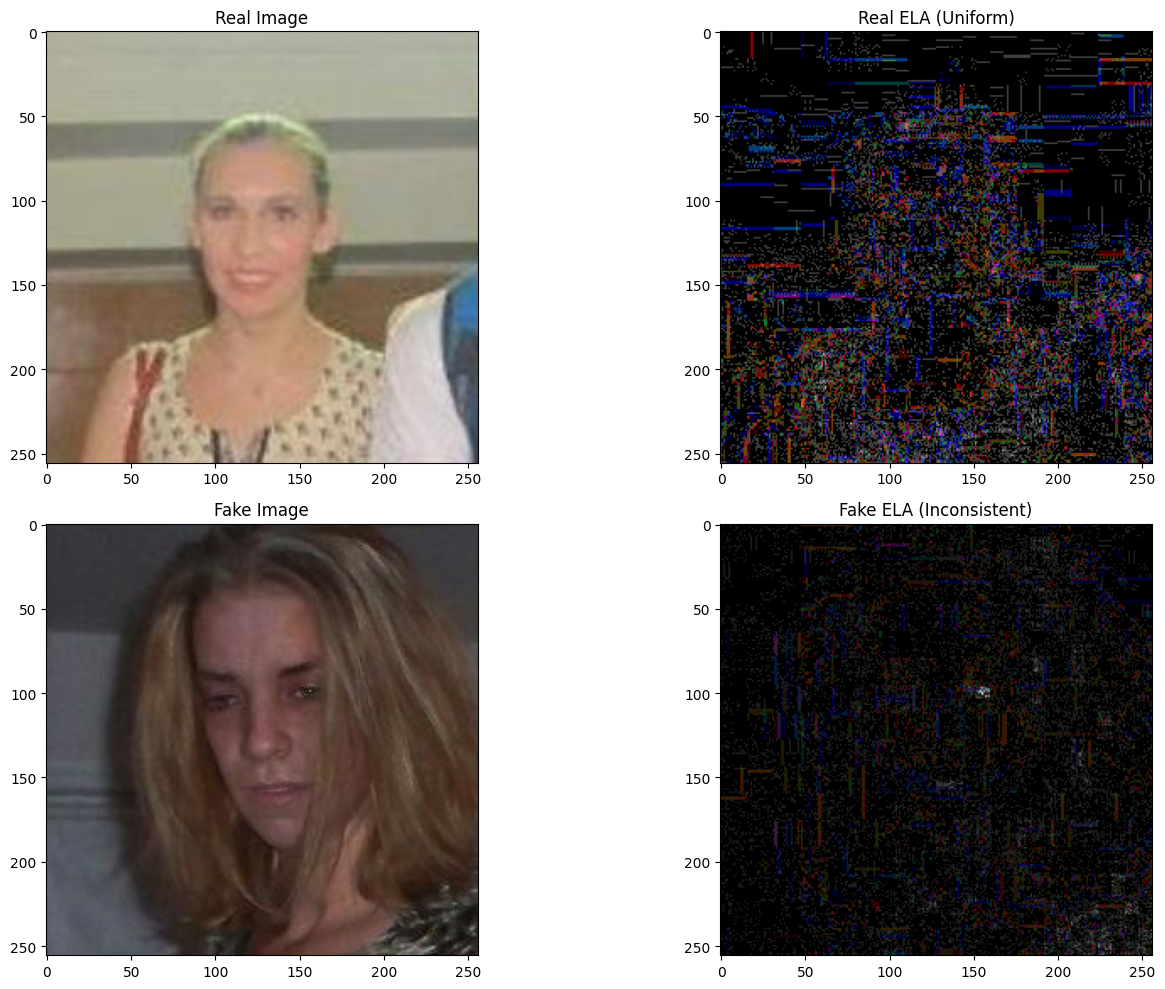

In [6]:

def get_class_counts(dirs):
    data = []
    for name, path in dirs.items():
        for label in ['Real', 'Fake']: # Ensure these match your folder names
            count = len(os.listdir(os.path.join(path, label)))
            data.append({'Dataset': name, 'Class': label, 'Count': count})
    return pd.DataFrame(data)

def perform_ela(image_path, quality=90):
    """Calculates the compression error difference in an image."""
    original = Image.open(image_path).convert('RGB')
    resaved_name = 'temp_resaved.jpg'
    original.save(resaved_name, 'JPEG', quality=quality)
    resaved = Image.open(resaved_name)

    # Calculate difference and enhance for visibility
    ela_im = ImageChops.difference(original, resaved)
    extrema = ela_im.getextrema()
    max_diff = max([ex[1] for ex in extrema])
    scale = 255.0 / max_diff if max_diff != 0 else 1
    return ImageEnhance.Brightness(ela_im).enhance(scale)

# 1. Check Distributions
directories = {
    "Train": train_directory,
    "Val": val_directory,
    "Test": test_directory
}

df_counts = get_class_counts(directories)
print("--- Class Distribution ---")
print(df_counts.pivot(index='Dataset', columns='Class', values='Count'))

# 2. Visualize Forensic Signatures
sample_real = os.path.join(train_directory, "Real", os.listdir(train_directory + "/Real")[0])
sample_fake = os.path.join(train_directory, "Fake", os.listdir(train_directory + "/Fake")[0])

plt.figure(figsize=(15, 10))

# Real Image & ELA
plt.subplot(2, 2, 1); plt.imshow(Image.open(sample_real)); plt.title("Real Image")
plt.subplot(2, 2, 2); plt.imshow(perform_ela(sample_real)); plt.title("Real ELA (Uniform)")

# Fake Image & ELA
plt.subplot(2, 2, 3); plt.imshow(Image.open(sample_fake)); plt.title("Fake Image")
plt.subplot(2, 2, 4); plt.imshow(perform_ela(sample_fake)); plt.title("Fake ELA (Inconsistent)")

plt.tight_layout()
plt.show()

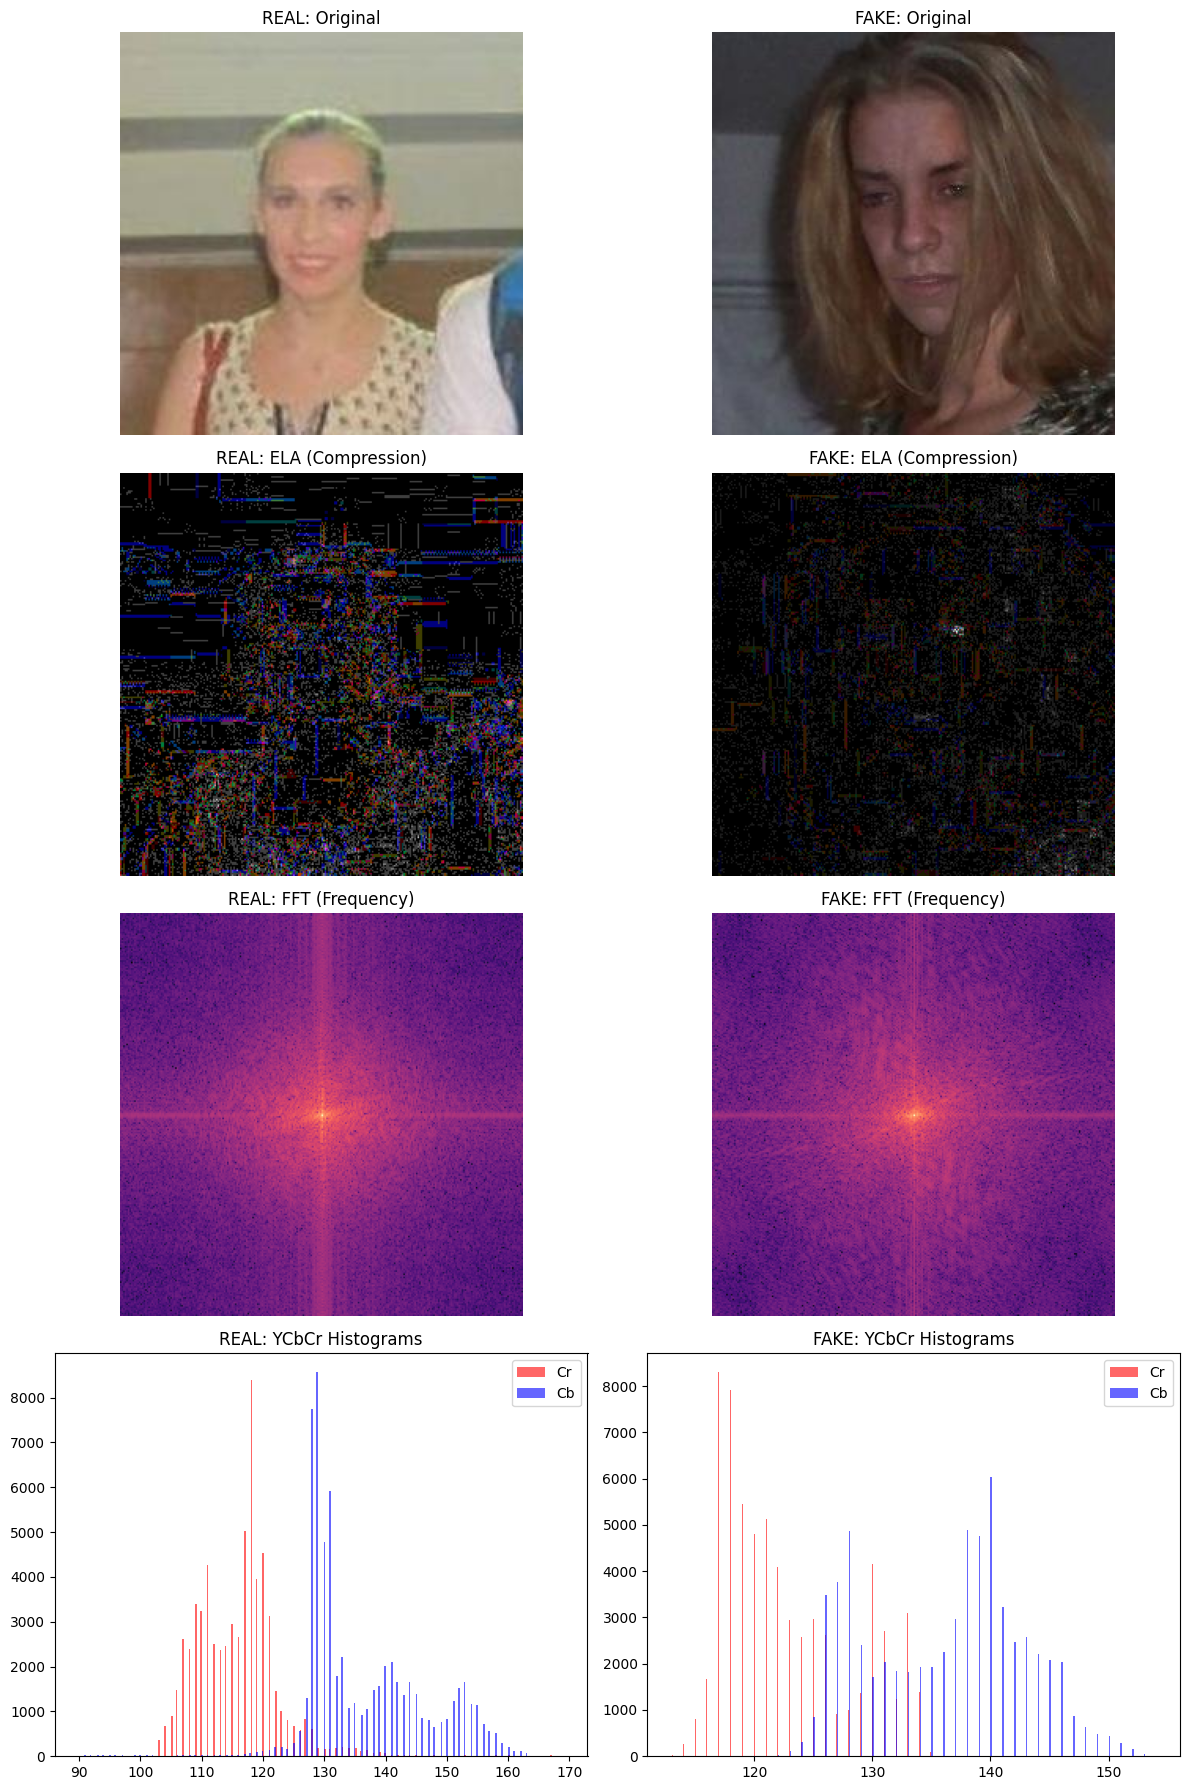

In [8]:
def get_forensic_analysis(real_path, fake_path, quality=90):
    fig, axes = plt.subplots(4, 2, figsize=(12, 18))

    paths = [real_path, fake_path]
    titles = ['REAL', 'FAKE']

    for i, path in enumerate(paths):
        # 1. Original Image
        img_bgr = cv2.imread(path)
        img_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)
        axes[0, i].imshow(img_rgb)
        axes[0, i].set_title(f"{titles[i]}: Original")
        axes[0, i].axis('off')

        # 2. Error Level Analysis (ELA)
        original = Image.open(path).convert('RGB')
        original.save('temp.jpg', 'JPEG', quality=quality)
        resaved = Image.open('temp.jpg')
        ela_im = ImageChops.difference(original, resaved)
        extrema = ela_im.getextrema()
        max_diff = max([ex[1] for ex in extrema])
        scale = 255.0 / max_diff if max_diff != 0 else 1
        ela_im = ImageEnhance.Brightness(ela_im).enhance(scale)
        axes[1, i].imshow(ela_im)
        axes[1, i].set_title(f"{titles[i]}: ELA (Compression)")
        axes[1, i].axis('off')

        # 3. FFT (Frequency Domain)
        gray = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2GRAY)
        f = np.fft.fft2(gray)
        fshift = np.fft.fftshift(f)
        magnitude_spectrum = 20 * np.log(np.abs(fshift) + 1)
        axes[2, i].imshow(magnitude_spectrum, cmap='magma')
        axes[2, i].set_title(f"{titles[i]}: FFT (Frequency)")
        axes[2, i].axis('off')

        # 4. YCbCr (Chrominance/Color Distribution)
        ycbcr = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2YCrCb)
        # We plot the Cr (Red-difference) channel as it's sensitive to skin tones
        axes[3, i].hist(ycbcr[:,:,2].ravel(), bins=256, color='red', alpha=0.6, label='Cr')
        axes[3, i].hist(ycbcr[:,:,1].ravel(), bins=256, color='blue', alpha=0.6, label='Cb')
        axes[3, i].set_title(f"{titles[i]}: YCbCr Histograms")
        axes[3, i].legend()

    plt.tight_layout()
    plt.show()

# Run the analysis on your data
sample_real = os.path.join(train_directory, "Real", os.listdir(train_directory + "/Real")[0])
sample_fake = os.path.join(train_directory, "Fake", os.listdir(train_directory + "/Fake")[0])
get_forensic_analysis(sample_real, sample_fake)

In deepfake detection, you should absolutely keep the train, validate and test separate. Merging them can lead to "Data Leakage." If the model sees even a glimpse of the test distribution during training, your accuracy will look amazing in the notebook but fail miserably in the real world.

The distribution of real and fake images in all the 3 datasets - train, validate and test are fairly balanced

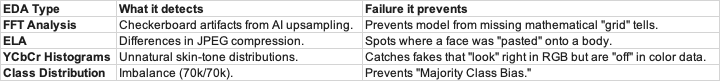

In [3]:
import io
import numpy as np
import tensorflow as tf
from flask import Flask, request, jsonify
from PIL import Image
from tensorflow.keras.preprocessing.image import img_to_array

app = Flask(__name__)

# Load EfficientNetB0 model
MODEL_PATH = '/content/drive/MyDrive/MLZoomCamp/Capstone2/best_model_finetuned.keras'
model = tf.keras.models.load_model(MODEL_PATH)

def prepare_image(image_bytes):
    # 1. Load image and convert to RGB
    img = Image.open(io.BytesIO(image_bytes)).convert('RGB')

    # 2. Resize to EfficientNetB0's native 224x224
    img = img.resize((224, 224))

    # 3. Convert to array and add batch dimension
    img_array = img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)

    # IMPORTANT: EfficientNetB0 has internal rescaling (0-255).
    # Do NOT divide by 255.0 here unless you removed that layer during training.
    return img_array

@app.route('/predict', methods=['POST'])
def predict():
    if 'image' not in request.files:
        return jsonify({'error': 'No image provided'}), 400

    # Read the file from the request
    file = request.files['image'].read()

    # Preprocess
    processed_image = prepare_image(file)

    # Run Inference
    prediction = model.predict(processed_image)[0][0]

    # Determine Label (Assuming 0=Real, 1=Fake)
    label = "Fake" if prediction > 0.5 else "Real"
    confidence = float(prediction) if label == "Fake" else float(1 - prediction)

    return jsonify({
        'status': 'success',
        'prediction': label,
        'confidence': f"{confidence:.2%}"
    })

# Start Flask in a background thread for Colab compatibility
import threading
threading.Thread(target=app.run, kwargs={'host':'0.0.0.0', 'port':9696}).start()

In [9]:
!curl -X POST -F "image=@/content/Capstone2/dataset/Test/Real/real_1003.jpg" http://localhost:9696/predict

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


INFO:werkzeug:127.0.0.1 - - [31/Jan/2026 06:14:51] "POST /predict HTTP/1.1" 200 -


{"confidence":"61.07%","prediction":"Real","status":"success"}
